In [1]:
import numpy as np;
from visualize import plot_2, plot_3, plot_3d, plot_6;
from load_dataset import load_mnist_test, load_mnist_train;
from conduct_svm import svm;
from conduct_csc import nn_csc, csc, par_csc, par_nn_csc;
from pickless import output;
from pooling import forward;
from sporco import plot, util;
from sporco.admm import cbpdn
from conduct_svm import *;

In [5]:
def make_option():
    opt = {};
    # 訓練画像の枚数
    opt['train_amount'] = 500;
    # テスト画像の枚数
    opt['test_amount'] = 1000;
    # フィルタのサイズ
    opt['d_size'] = [(5, 5, 1, 1, 6), (5, 5, 16, 6)];
    # スパースの尺度
    opt['lmbda'] = [0.05, 0.025];
    # 繰り返し回数
    opt['Iter'] = [400, 400];
    # NMFによる錐制約部分空間法における基底の数
    opt['d_num'] = 16;
    # PCAによる包括凸錐による部分空間法における累積寄与率のリスト・パラメータ
    opt["ratios"] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 0.999, 0.9999];
    opt["params"] = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0];
    return opt;

In [6]:
opt = make_option();
train_data, train_label = load_mnist_train(opt["train_amount"]);
test_data, test_label = load_mnist_test(opt["test_amount"]);
train_data = np.expand_dims(train_data.transpose(1,2,0), 2);
test_data = np.expand_dims(test_data.transpose(1,2,0), 2);
test_data = np.expand_dims(test_data, -1);

/home/tomoya/anaconda3/envs/thesis/lib/python3.7/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/tomoya/anaconda3/envs/thesis/lib/python3.7/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


load_mnist_train: return following shape arrays
imgs: (500, 32, 32)
labels: (500,)
load_mnist_test: return following shape arrays
imgs: (1000, 32, 32)
labels: (1000,)


/home/tomoya/anaconda3/envs/thesis/lib/python3.7/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/tomoya/anaconda3/envs/thesis/lib/python3.7/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [7]:
train_data.shape

(32, 32, 1, 500)

### 学習用データセットで畳み込み辞書学習
第１層目:フォワードパスの計算中...
Itn   Fnc       DFid      ℓ1        Cnstr     r_X       s_X       ρ_X       r_D       s_D       ρ_D     
--------------------------------------------------------------------------------------------------------
   0  1.03e+04  7.94e+03  4.67e+04  1.89e-07  7.61e-01  8.18e-01  3.00e+00  2.15e-01  3.94e-01  1.00e+01
   1  1.10e+04  7.89e+03  6.23e+04  1.83e-07  3.20e-01  1.64e+00  3.00e+00  1.70e-01  3.22e-01  1.00e+01
   2  8.03e+03  4.37e+03  7.32e+04  1.47e-07  1.72e-01  8.80e-01  3.00e+00  1.20e-01  1.34e-01  1.00e+01
   3  7.32e+03  3.96e+03  6.71e+04  1.80e-07  1.16e-01  8.38e-01  3.00e+00  9.19e-02  9.71e-02  1.00e+01
   4  6.84e+03  3.62e+03  6.44e+04  1.69e-07  8.48e-02  5.13e-01  3.00e+00  7.28e-02  1.20e-01  1.00e+01
   5  6.55e+03  3.45e+03  6.19e+04  1.90e-07  6.17e-02  3.67e-01  3.00e+00  5.77e-02  9.27e-02  1.00e+01
   6  6.33e+03  3.34e+03  5.98e+04  2.09e-07  5.00e-02  3.23e-01  3.00e+00  5.02e-02  6.91e-02  1.00e+01
   7  6.18e+

/home/tomoya/anaconda3/envs/thesis/lib/python3.7/site-packages/sporco/plot.py:673: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


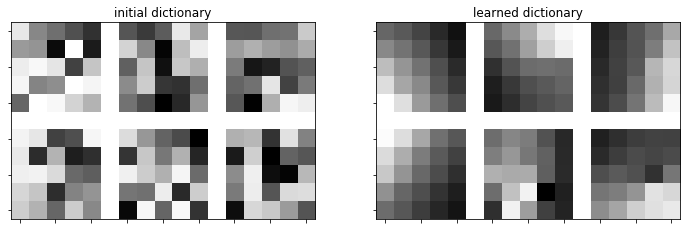

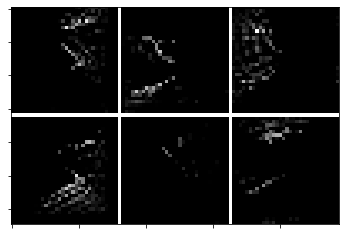

In [18]:
# 学習用データセットで辞書学習
print("### 学習用データセットで畳み込み辞書学習");

print("第１層目:フォワードパスの計算中...");
d0, D0, coef0_ = nn_csc(input_ = np.float32(train_data), d_size = opt['d_size'][0], lmbda = opt['lmbda'][0], Iter = opt['Iter'][0], visualize = True);

plot.imview(util.tiledict(coef0_[:, :, 0, 0, 0:16]));

In [98]:
def power_spectrum(img):
    return np.abs(np.fft.fftshift(np.fft.fft2(img)))

/home/tomoya/anaconda3/envs/thesis/lib/python3.7/site-packages/sporco/plot.py:673: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fec336175d0>)

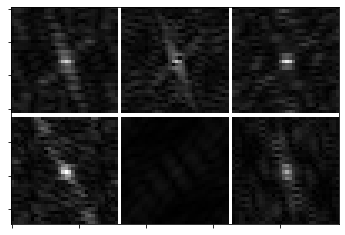

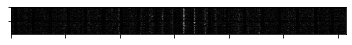

In [99]:
coef = np.zeros_like(coef0_)
for i in range(opt['train_amount']):
    for j in range(coef0_.shape[4]):
        coef[:, :, 0, i, j] = power_spectrum(coef0_[:, :, 0, i, j]);        
plot.imview(util.tiledict(coef[:, :, 0, 0, 0:6]));
train_feature = coef.transpose(3, 0, 1, 2, 4).squeeze().reshape(opt["train_amount"], -1);
plot.imview(train_feature)

In [100]:
from sklearn.decomposition import NMF;
nmf = NMF(n_components = 256);
nmf.fit(train_feature);
train_feature = nmf.transform(train_feature);

In [64]:
# 学習用の非負特徴量(data_num, data_dim)
train_feature = coef2.reshape(opt["train_amount"], -1)

NameError: name 'coef2' is not defined

In [102]:
# テスト用データセットの係数算出
print("### テスト用データセットの係数算出 ###");

test_opt0 = cbpdn.ConvBPDN.Options({'Verbose': False, 'MaxMainIter': opt["Iter"][0], 'RelStopTol': 5e-3, 'AuxVarObj': False, 'NonNegCoef':True});
b0 = cbpdn.ConvBPDN(np.float32(D0), np.float32(test_data), opt["lmbda"][0], test_opt0);
print("第１層目:フォワードパスの計算中...");
test_coef0 = b0.solve();

for i in range(opt['test_amount']):
    for j in range(test_coef0.shape[4]):
        test_coef0[:, :, 0, i, j] = power_spectrum(test_coef0[:, :, 0, i, j])
        
test_feature = test_coef0.transpose(3, 0, 1, 2, 4).squeeze().reshape(opt["test_amount"], -1);
test_feature = nmf.transform(test_feature);

### テスト用データセットの係数算出 ###
第１層目:フォワードパスの計算中...


In [104]:
# SVMによる分類
clf = train_svm(train_feature, train_label);
test_precision = test_svm(clf, test_feature, test_label);

Train precision:  1.0
Test precision:  0.392


In [105]:
# 錘を作るための関数郡
from sklearn.decomposition import NMF
def create_cone_NMF(feature, num):
    nmf = NMF(n_components=num);
    W = nmf.fit_transform(feature);
    H = nmf.components_;
    return nmf, H, W;

def restore_from_cone_NMF(feature, nmf):
    restore = nmf.inverse_transform(nmf.transform(feature));
    return restore;

In [110]:
# 学習データの錘を作成
# H: 錐の基底ベクトル
# W: 非負値結合係数
# nmf: NMFクラス

NMFs = [];
Hs = [];
Ws = [];
for i in range(10):
    print(str(i)+"番目のクラスの錐を作成中...");
    nmf, H, W = create_cone_NMF(train_feature[train_label == i], opt["d_num"]);
    NMFs.append(nmf);
    Hs.append(H);
    Ws.append(W);

0番目のクラスの錐を作成中...
1番目のクラスの錐を作成中...
2番目のクラスの錐を作成中...
3番目のクラスの錐を作成中...
4番目のクラスの錐を作成中...
5番目のクラスの錐を作成中...
6番目のクラスの錐を作成中...
7番目のクラスの錐を作成中...
8番目のクラスの錐を作成中...
9番目のクラスの錐を作成中...


In [111]:
# テストデータを錐へ射影
# restore: 射影したベクトル
restores = [];
for i in range(10):
    print(str(i)+"番目のクラスの錐で入力を再現中...")
    temp = restore_from_cone_NMF(test_feature, NMFs[i]);
    restores.append(temp);

0番目のクラスの錐で入力を再現中...
1番目のクラスの錐で入力を再現中...
2番目のクラスの錐で入力を再現中...
3番目のクラスの錐で入力を再現中...
4番目のクラスの錐で入力を再現中...
5番目のクラスの錐で入力を再現中...
6番目のクラスの錐で入力を再現中...
7番目のクラスの錐で入力を再現中...
8番目のクラスの錐で入力を再現中...
9番目のクラスの錐で入力を再現中...


In [112]:
from sklearn.metrics.pairwise import cosine_similarity;
CosArray = [];
for i in range(10):
    cos_array = cosine_similarity(test_feature, restores[i]);
    CosArray.append(np.diag(cos_array));
CosArray = np.array(CosArray);
predict_label = np.argmax(CosArray, axis = 0);
precision = sum(predict_label == test_label)/test_label.shape[0];
print('Test precision: ', precision);

Test precision:  0.635


In [127]:
def NMF_Classifier(train_feature, train_label, test_feature, test_label, from_, to_):
    accuracy = []
    forcsv = []
    for h in range(from_, to_+1):
        NMFs = [];
        Hs = [];
        Ws = [];
        for i in range(10):
            #print(str(i)+"番目のクラスの錐を作成中...");
            nmf, H, W = create_cone_NMF(train_feature[train_label == i], h);
            NMFs.append(nmf);
            Hs.append(H);
            Ws.append(W);
        restores = [];
        for i in range(10):
            #print(str(i)+"番目のクラスの錐で入力を再現中...")
            temp = restore_from_cone_NMF(test_feature, NMFs[i]);
            restores.append(temp);
        CosArray = [];
        for i in range(10):
            cos_array = cosine_similarity(test_feature, restores[i]);
            CosArray.append(np.diag(cos_array));            
        CosArray = np.array(CosArray);
        predict_label = np.argmax(CosArray, axis = 0);
        precision = sum(predict_label == test_label)/test_label.shape[0];
        accuracy.append(precision);
        forcsv.append([h, precision])
        print("d_num="+str(h)+": Test precision: ", precision);
    fig = plot.figure();
    ax = fig.add_subplot(111);
    ax.set_xlabel("# of basis");
    ax.set_ylabel("Accuracy");
    ax.set_ylim(0.0, 1.0);
    ax.plot(accuracy);
    ax.set_title("Cone restricted subspace method by NMF");
    fig.savefig("result/mnist_nmf.png")
    with open("./result/nn_mnist_spectrum_nmf.csv", "w") as f:
        writer = csv.writer(f)
        writer.writerow(["dim","accuracy"])
        writer.writerows(forcsv)

d_num=1: Test precision:  0.319
d_num=2: Test precision:  0.384
d_num=3: Test precision:  0.431
d_num=4: Test precision:  0.464
d_num=5: Test precision:  0.487
d_num=6: Test precision:  0.515
d_num=7: Test precision:  0.521
d_num=8: Test precision:  0.543
d_num=9: Test precision:  0.568
d_num=10: Test precision:  0.573
d_num=11: Test precision:  0.579
d_num=12: Test precision:  0.585
d_num=13: Test precision:  0.61
d_num=14: Test precision:  0.625
d_num=15: Test precision:  0.631
d_num=16: Test precision:  0.635
d_num=17: Test precision:  0.641
d_num=18: Test precision:  0.642
d_num=19: Test precision:  0.634
d_num=20: Test precision:  0.664
d_num=21: Test precision:  0.66
d_num=22: Test precision:  0.67
d_num=23: Test precision:  0.68
d_num=24: Test precision:  0.691
d_num=25: Test precision:  0.683
d_num=26: Test precision:  0.686
d_num=27: Test precision:  0.69
d_num=28: Test precision:  0.694
d_num=29: Test precision:  0.699
d_num=30: Test precision:  0.7
d_num=31: Test precision: 

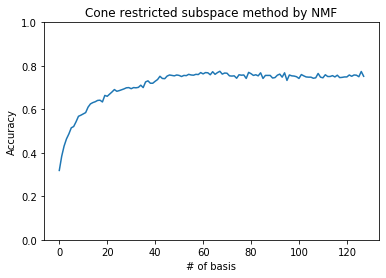

In [128]:
NMF_Classifier(train_feature, train_label, test_feature, test_label, 1, 128);

In [115]:
from sklearn.preprocessing import normalize
from sporco import prox
test_feature_norm = normalize(test_feature);

[[1.00000000e+00 4.67685551e-04 1.61230965e-03 3.84926102e-04
  3.17457822e-04 7.89926830e-04 7.08730708e-05 1.57710543e-04
  1.29018283e-03 4.18244559e-04 1.15871590e-03 3.55531592e-04
  1.35667112e-03 1.08640490e-03 4.84403914e-04 9.87703572e-03]
 [4.67685551e-04 1.00000000e+00 9.71501797e-02 1.18243138e-02
  1.61450548e-03 1.17151379e-03 1.67949181e-04 1.25702034e-03
  9.03996525e-04 1.36264602e-03 4.05731812e-03 1.98215611e-03
  1.31653830e-01 1.67389155e-02 2.73865728e-03 1.28081366e-02]
 [1.61230965e-03 9.71501797e-02 1.00000000e+00 1.72726054e-03
  5.91975653e-04 6.97413935e-04 3.96177145e-04 1.25796383e-03
  2.10618919e-03 1.89921575e-03 2.51124765e-03 1.20635302e-03
  1.80890472e-02 3.29741765e-03 1.43053918e-03 1.04502386e-02]
 [3.84926102e-04 1.18243138e-02 1.72726054e-03 1.00000000e+00
  9.49757955e-04 4.08114597e-03 1.05351439e-03 1.96354546e-03
  1.60561417e-03 8.20952670e-04 1.75541974e-03 3.01995979e-04
  4.29506143e-03 2.59197381e-03 1.93153242e-03 5.65446311e-03]
 [3.

/home/tomoya/anaconda3/envs/thesis/lib/python3.7/site-packages/sporco/plot.py:673: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


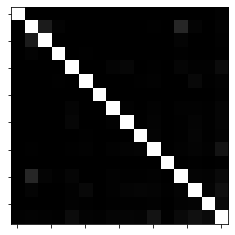

In [116]:
Hs[0].shape
H0 = normalize(Hs[0]);
corr_0 = H0.dot(H0.T);
plot.imview(corr_0);
print(corr_0);

In [117]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
param = 1.0;
ratio = 0.9;
# feature = normalize(np.random.uniform(0.0, 1.0, (500, 1024)));
feature = normalize(test_feature);
pca = PCA(n_components=ratio);
pca.fit(feature);
variance = pca.explained_variance_;
mean = pca.mean_;
basis = pca.components_;
cone_basis = [];
cnt = 0;
for i in variance:
    cone_basis.append(mean+param*np.sqrt(i)*basis[cnt]);
    cone_basis.append(mean-param*np.sqrt(i)*basis[cnt]);
    cnt=cnt+1;
cone_basis = np.array(cone_basis);

In [118]:
from scipy.optimize import nnls;

def create_cone_PCA(feature, param, ratio):
    feature = normalize(feature);
    pca = PCA(n_components=ratio);
    pca.fit(feature);
    variance = pca.explained_variance_;
    mean = pca.mean_;
    basis = pca.components_;
    cone_basis = [];
    cnt = 0;
    for i in variance:
        cone_basis.append(mean+param*np.sqrt(i)*basis[cnt]);
        cone_basis.append(mean-param*np.sqrt(i)*basis[cnt]);
        cnt=cnt+1;
    cone_basis = np.array(cone_basis);
    return cone_basis;

def restore_from_cone_PCA(cone_basis, feature):
    feature = list(feature);
    restore = [];
    for i in feature:
        x = np.array(nnls(cone_basis.T, i)[0]);
        restore.append(cone_basis.T.dot(x));
    restore = np.array(restore);
    return restore;

In [119]:
cone_basis = create_cone_PCA(train_feature, 1.0, 0.9);

In [120]:
feature = list(feature)
restore = [];
for i in feature:
    x = np.array(nnls(cone_basis.T, i)[0]);
    restore.append(cone_basis.T.dot(x));
restore = np.array(restore);
#x = nnls(cone_basis, feature);

In [131]:
from matplotlib import pyplot as plt
import csv
def PCA_Classifier(train_feature, train_label, test_feature, test_label, params, ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 0.999, 0.9999]):
    forcsv = []
    fig = plot.figure();
    ax = fig.add_subplot(111);
    cmap = plt.get_cmap("tab10");
    ax.set_title("Cone restricted subspace method by Comprehensive cone");
    ax.set_xlabel("Contribution rates of principal components");
    ax.set_ylabel("Accuracy");
    ax.set_ylim(0.0, 1.0);
    cnt=0;
    for param in params:
        forcsv.append(["scaling param", str(param)])
        forcsv.append(["contribution rate", "accuracy"])
        accuracy = [];
        print("the parameter of scaling : "+str(param))
        for ratio in ratios:
            Cones = [];

            for i in range(10):
                #print(str(i)+"番目のクラスの錐を作成中...");
                cone = create_cone_PCA(train_feature[train_label == i], param, ratio);
                Cones.append(cone);
            restores = [];
            for i in range(10):
                #print(str(i)+"番目のクラスの錐で入力を再現中...")
                temp = restore_from_cone_PCA(Cones[i], test_feature);
                restores.append(temp);
            CosArray = [];
            for i in range(10):
                cos_array = cosine_similarity(test_feature, restores[i]);
                CosArray.append(np.diag(cos_array));

            CosArray = np.array(CosArray);
            predict_label = np.argmax(CosArray, axis = 0);
            precision = sum(predict_label == test_label)/test_label.shape[0];
            print("ratio="+str(ratio)+": Test precision: ", precision);
            forcsv.append([ratio, precision])
            accuracy.append(precision);
        ax.plot(accuracy, label = "k="+str(param), color = cmap(cnt));
        cnt=cnt+1;
    ax.legend();
    fig.savefig("result/Cmnist_omprehensive.png");
    with open("./result/nn_mnist_spectrum_pca.csv", "w") as f:
        writer = csv.writer(f)
        writer.writerows(forcsv)

the parameter of scaling : 0.5
ratio=0.1: Test precision:  0.682
ratio=0.2: Test precision:  0.701
ratio=0.3: Test precision:  0.708
ratio=0.4: Test precision:  0.705
ratio=0.5: Test precision:  0.703
ratio=0.6: Test precision:  0.703
ratio=0.7: Test precision:  0.705
ratio=0.8: Test precision:  0.704
ratio=0.9: Test precision:  0.706
ratio=0.99: Test precision:  0.706
ratio=0.999: Test precision:  0.706
ratio=0.9999: Test precision:  0.706
the parameter of scaling : 1.0
ratio=0.1: Test precision:  0.672
ratio=0.2: Test precision:  0.692
ratio=0.3: Test precision:  0.715
ratio=0.4: Test precision:  0.717
ratio=0.5: Test precision:  0.719
ratio=0.6: Test precision:  0.722
ratio=0.7: Test precision:  0.723
ratio=0.8: Test precision:  0.723
ratio=0.9: Test precision:  0.725
ratio=0.99: Test precision:  0.725
ratio=0.999: Test precision:  0.725
ratio=0.9999: Test precision:  0.725
the parameter of scaling : 1.5
ratio=0.1: Test precision:  0.669
ratio=0.2: Test precision:  0.691
ratio=0.3: 

NameError: name 'csv' is not defined

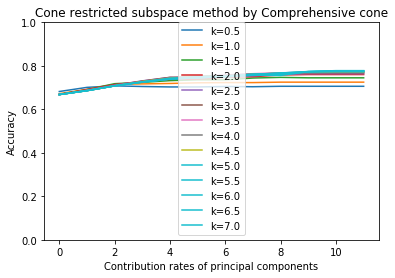

In [130]:
PCA_Classifier(train_feature, train_label, test_feature, test_label, opt["params"], opt["ratios"]);

ratio=0.1: Test precision:  0.764
ratio=0.2: Test precision:  0.793
ratio=0.3: Test precision:  0.824
ratio=0.4: Test precision:  0.828
ratio=0.5: Test precision:  0.829
ratio=0.6: Test precision:  0.84
ratio=0.7: Test precision:  0.83
ratio=0.8: Test precision:  0.825
ratio=0.9: Test precision:  0.823
ratio=0.99: Test precision:  0.823
ratio=0.999: Test precision:  0.823
ratio=0.9999: Test precision:  0.823


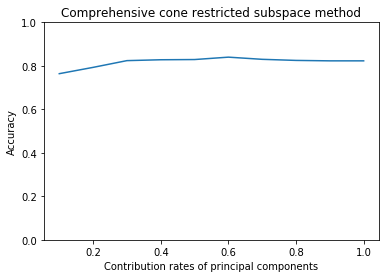

In [58]:
accuracy = [];
for ratio in opt["ratios"]:
    Cones = [];
    
    for i in range(10):
        cone =  create_cone_PCA(train_feature[train_label == i], 6.0, ratio);
        Cones.append(cone);
        
    restores = [];
    for i in range(10):
        temp = restore_from_cone_PCA(Cones[i], test_feature);
        restores.append(temp);
        
    CosArray = []
    for i in range(10):
        cos_array = cosine_similarity(test_feature, restores[i]);
        CosArray.append(np.diag(cos_array));
    
    CosArray = np.array(CosArray);
    predict_label = np.argmax(CosArray, axis = 0);
    precision = sum(predict_label == test_label)/test_label.shape[0];
    print("ratio="+str(ratio)+": Test precision: ", precision);
    accuracy.append(precision);
    
fig = plot.figure();
ax = fig.add_subplot(111);
ax.set_xlabel("Contribution rates of principal components");
ax.set_ylabel("Accuracy");
ax.set_ylim(0.0, 1.0);
# ax.plot(accuracy);
ax.set_title("Comprehensive cone restricted subspace method");
ax.plot(opt["ratios"], accuracy, label = "k="+str(param));
fig.savefig("result/pca_best.png")

In [53]:
ax.plot(opt["ratios"], accuracy, label = "k="+str(param));

'    \n    predict_label = np.argmax(CosArray, axis = 0);\n    precision = sum(preict_label == test_label)/test_label.shape[0];\n    print("ratio="+str(ratio)+": Test precision: ", precision);\n    accuracy.append(precision);\n    \nfig = plot.figure();\nax = fig.add_subplot(111);\nax.set_xlabel("Contribution rates of principal components");\nax.set_ylabel("Accuracy");\nax.set_ylim(0.0, 1.0);\n# ax.plot(accuracy);\nax.set_title("Comprehensive cone restricted subspace method");\nax.plot(opt["ratios"], accuracy, label = "k="+str(param));\nfig.savefig("result/pca_best.png")\n'

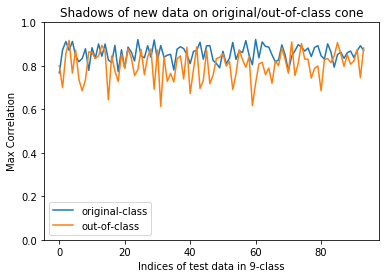

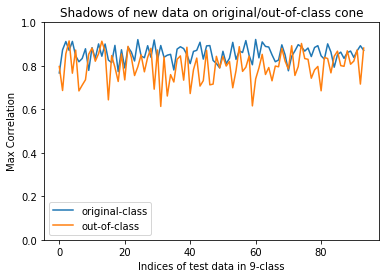

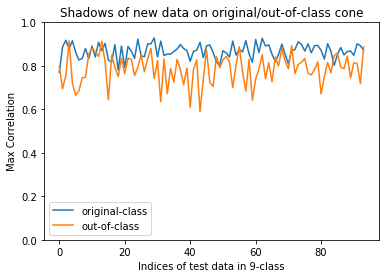

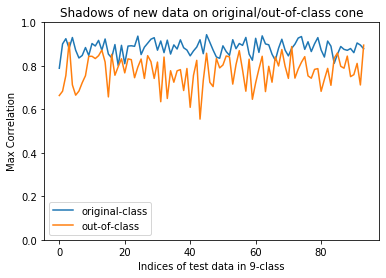

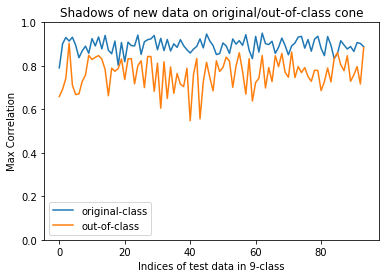

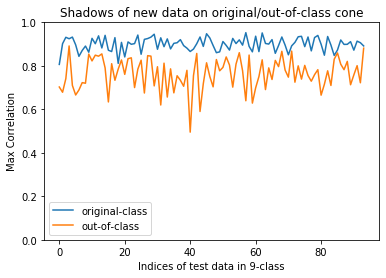

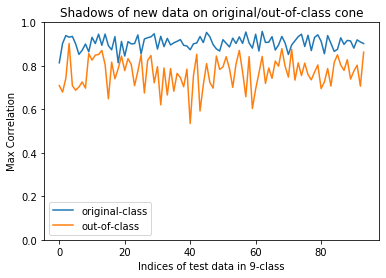

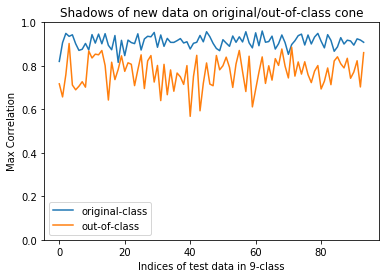

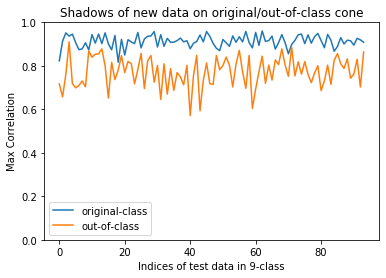

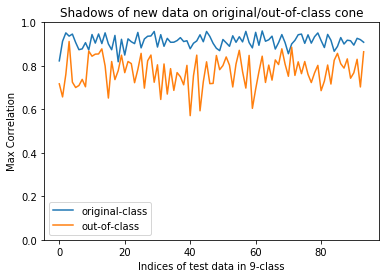

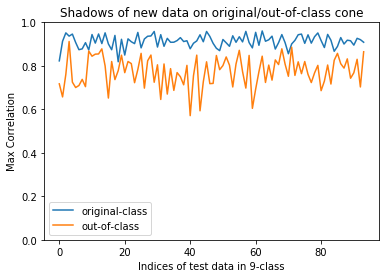

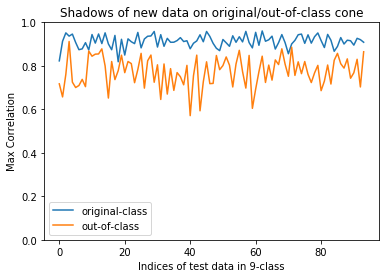

In [84]:
# 学習済みの凸錐から, 学習データにないクラスの係数を復元させ, 影の長さを取得
for ratio in opt["ratios"]:
    Cones = [];
    
    original_cone = create_cone_PCA(train_feature[train_label==9], 6.0, ratio);
    original_temp = restore_from_cone_PCA(original_cone, test_feature[test_label==9]);
    shadow = np.diag(cosine_similarity(test_feature[test_label == 9], original_temp));
    
    for i in range(9):
        cone =  create_cone_PCA(train_feature[train_label == i], 6.0, ratio);
        Cones.append(cone);
        
    restores = [];
    for i in range(9):
        temp = restore_from_cone_PCA(Cones[i], test_feature[test_label == 9]);
        restores.append(temp);
        
    CosArray = []
    for i in range(9):
        cos_array = cosine_similarity(test_feature, restores[i]);
        CosArray.append(np.diag(cos_array));
    
    CosArray = np.array(CosArray);
    error_max = np.max(CosArray, axis =0);
    fig = plot.figure();
    ax = fig.add_subplot(111);
    ax.set_xlabel("Indices of test data in 9-class");
    ax.set_ylabel("Max Correlation");
    ax.set_ylim(0.0, 1.0);
    # ax.plot(accuracy);
    ax.set_title("Shadows of new data on original/out-of-class cone");
    ax.plot(shadow, label = "original-class");
    ax.plot(error_max, label = "out-of-class");
    ax.legend();
    fig.savefig("result/out_corr_"+str(ratio)+".png");
    
    
"""    
    predict_label = np.argmax(CosArray, axis = 0);
    precision = sum(preict_label == test_label)/test_label.shape[0];
    print("ratio="+str(ratio)+": Test precision: ", precision);
    accuracy.append(precision);
    
fig = plot.figure();
ax = fig.add_subplot(111);
ax.set_xlabel("Contribution rates of principal components");
ax.set_ylabel("Accuracy");
ax.set_ylim(0.0, 1.0);
# ax.plot(accuracy);
ax.set_title("Comprehensive cone restricted subspace method");
ax.plot(opt["ratios"], accuracy, label = "k="+str(param));
fig.savefig("result/pca_best.png")
"""

/home/tomoya/anaconda3/envs/thesis/lib/python3.7/site-packages/sporco/plot.py:673: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5548cfc7d0>)

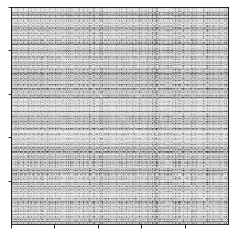

In [62]:
plot.imview(cos_array);

In [72]:
shadow.shape

(94,)